Pandas and duckdb

# Task 0 

##### Load the sakila_sqlite.duckdb into a duckdb database -> run load_sakila_sqlite_duckdb.py  ??????
##### With the help of dlt tool från duckdb_pandas.py one runs in command prompt ->  uv add "dlt[sql_database]" "dlt[parquet]" duckdb pandas ipykernel -> här skapas duckdb ???????
##### Then i also ran uv run load_sakila_sqlite_duckdb.py 

In [1]:
# Task 0 = load_sakila_sqlite.duckdb.py

import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

description

,database,schema,name,column_names,column_types,temporary
0,sakila,staging,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,sakila,staging,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,sakila,staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,sakila,staging,actor,"[actor_id, first_name, last_name, last_update,...","[DECIMAL(38,9), VARCHAR, VARCHAR, TIMESTAMP, V...",False
4,sakila,staging,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
5,sakila,staging,category,"[category_id, name, last_update, _dlt_load_id,...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
6,sakila,staging,city,"[city_id, city, country_id, last_update, _dlt_...","[BIGINT, VARCHAR, BIGINT, TIMESTAMP, VARCHAR, ...",False
7,sakila,staging,country,"[country_id, country, last_update, _dlt_load_i...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
8,sakila,staging,customer,"[customer_id, store_id, first_name, last_name,...","[BIGINT, BIGINT, VARCHAR, VARCHAR, VARCHAR, BI...",False
9,sakila,staging,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",False


In [ ]:
# Task 0 = load_sakila.sql


# import duckdb
# from pathlib import Path

# duckdb_path = "data/sakila.duckdb"
# Path(duckdb_path).unlink(missing_ok=True)

# with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
#     conn.sql(ingest_script.read())

#     description = conn.sql("DESC;").df()
#     films = conn.sql("FROM film;").df()

        

# films.head() 

In [ ]:
# description

### Task 1

###  Read all data into dictionary of pandas dataframes

In [2]:
dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM staging.{name};").df()
        duckdb.register(name, dfs[name])

dfs.keys()

dict_keys(['_dlt_loads', '_dlt_pipeline_state', '_dlt_version', 'actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'inventory', 'language', 'payment', 'rental', 'staff', 'store'])

In [ ]:
# task 1a)
#  Which movies are longer than 3 hours (180 minutes), show the title and its length?

length_of_movie=duckdb.sql("""    
    SELECT title, length AS movie_length
    FROM film
    WHERE length > 180;         
    """).df()

length_of_movie.head()

In [ ]:
# task 1b)
# Which movies have the word "love" in its title? Show the following columns :title, rating, length, description

love_word=duckdb.sql("""
SELECT title, rating, length, description
FROM film
WHERE title ILIKE '%love%';
""").df()

love_word.head()

In [ ]:
# task 1c)
# Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

length_statistik=duckdb.sql("""
SELECT
MIN(length) AS shortest,
MAX(length) AS longest,
AVG(length) AS average,
MEDIAN(length) AS median 
FROM film;                          
""").df()

length_statistik.head()



In [3]:
# task 1d)
#  The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can  keep the movie. The Manager wants to know the 10 most expensive movies to rent per day

expensive_movies=duckdb.sql("""
SELECT title, rental_rate, rental_duration, (rental_rate / rental_duration) AS cost_per_day
FROM film
ORDER BY cost_per_day DESC
LIMIT 10;                              
""").df()

expensive_movies

,title,rental_rate,rental_duration,cost_per_day
0,AMERICAN CIRCUS,4.99,3,1.663333
1,BACKLASH UNDEFEATED,4.99,3,1.663333
2,BILKO ANONYMOUS,4.99,3,1.663333
3,BEAST HUNCHBACK,4.99,3,1.663333
4,CARIBBEAN LIBERTY,4.99,3,1.663333
5,AUTUMN CROW,4.99,3,1.663333
6,CASPER DRAGONFLY,4.99,3,1.663333
7,ACE GOLDFINGER,4.99,3,1.663333
8,BEHAVIOR RUNAWAY,4.99,3,1.663333
9,CASUALTIES ENCINO,4.99,3,1.663333


In [4]:
# task 1e)
# Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.

top_actors=duckdb.sql("""
SELECT a.actor_id, a.first_name, a.last_name, COUNT(*) AS film_count
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY film_count DESC
LIMIT 10;                      
""").df()

top_actors

,actor_id,first_name,last_name,film_count
0,107.0,GINA,DEGENERES,42
1,102.0,WALTER,TORN,41
2,198.0,MARY,KEITEL,40
3,181.0,MATTHEW,CARREY,39
4,23.0,SANDRA,KILMER,37
5,81.0,SCARLETT,DAMON,36
6,13.0,UMA,WOOD,35
7,37.0,VAL,BOLGER,35
8,106.0,GROUCHO,DUNST,35
9,144.0,ANGELA,WITHERSPOON,35


In [5]:
duckdb.sql("""from actor""")

┌──────────┬────────────┬──────────────┬─────────────────────┬───────────────────┬────────────────┐
│ actor_id │ first_name │  last_name   │     last_update     │   _dlt_load_id    │    _dlt_id     │
│  double  │  varchar   │   varchar    │      timestamp      │      varchar      │    varchar     │
├──────────┼────────────┼──────────────┼─────────────────────┼───────────────────┼────────────────┤
│      1.0 │ PENELOPE   │ GUINESS      │ 2021-03-06 15:51:59 │ 1764846174.189018 │ +Etw9a+quVGgIQ │
│      2.0 │ NICK       │ WAHLBERG     │ 2021-03-06 15:51:59 │ 1764846174.189018 │ YRbkt8JBFV8jyQ │
│      3.0 │ ED         │ CHASE        │ 2021-03-06 15:51:59 │ 1764846174.189018 │ kZg82B3KvEl8aQ │
│      4.0 │ JENNIFER   │ DAVIS        │ 2021-03-06 15:51:59 │ 1764846174.189018 │ x6DwthidyeJbfA │
│      5.0 │ JOHNNY     │ LOLLOBRIGIDA │ 2021-03-06 15:51:59 │ 1764846174.189018 │ ftaj87RmAt0IOw │
│      6.0 │ BETTE      │ NICHOLSON    │ 2021-03-06 15:51:59 │ 1764846174.189018 │ EPlSPq2vGCPXog │


In [6]:
duckdb.sql("""from film""")


┌─────────┬───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────┬─────────────┬──────────────────────┬─────────────────┬─────────────┬────────┬──────────────────┬─────────┬─────────────────────────────────────────┬─────────────────────┬───────────────────┬────────────────┐
│ film_id │       title       │                                                      description                                                      │ release_year │ language_id │ original_language_id │ rental_duration │ rental_rate │ length │ replacement_cost │ rating  │            special_features             │     last_update     │   _dlt_load_id    │    _dlt_id     │
│  int64  │      varchar      │                                                        varchar                                                        │   varchar    │    int64    │        int64         │      int64      │   double    │ int64  │      

In [8]:
# task 1f.1) 
# How many actors are there in each film?



tot_actors=duckdb.sql(""" 
SELECT
    title,
    COUNT(DISTINCT a.actor_id) AS actor_count
    FROM film f
    JOIN film_actor fa ON f.film_id = fa.film_id
    JOIN actor a ON a.actor_id = fa.actor_id    
    GROUP BY title
    ORDER BY actor_count DESC
    LIMIT 10;
""").df()

tot_actors

,title,actor_count
0,LAMBS CINCINATTI,15
1,DRACULA CRYSTAL,13
2,RANDOM GO,13
3,BOONDOCK BALLROOM,13
4,CHITTY LOCK,13
5,CRAZY HOME,13
6,MUMMY CREATURES,13
7,LESSON CLEOPATRA,12
8,LONELY ELEPHANT,12
9,SKY MIRACLE,12


In [9]:
# task 1f.2) 
# Top 10 most rented movies?

most_hired_movies=duckdb.sql("""
SELECT
    f.title,
    COUNT(*) AS rental_count
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.title
ORDER BY rental_count DESC
LIMIT 10;
""").df()

most_hired_movies

,title,rental_count
0,BUCKET BROTHERHOOD,34
1,ROCKETEER MOTHER,33
2,JUGGLER HARDLY,32
3,FORWARD TEMPLE,32
4,RIDGEMONT SUBMARINE,32
5,GRIT CLOCKWORK,32
6,SCALAWAG DUCK,32
7,ROBBERS JOON,31
8,APACHE DIVINE,31
9,NETWORK PEAK,31


In [10]:
# Kochan hjälpte mig men vi hittade inga bra lösning
# task 1f.3) 
# Which movies are returned the latest, meaning the films with the longest average return time?

latest_movies= duckdb.sql("""
SELECT
    f.title,
    extract(day from AVG(r.return_date - r.rental_date)) AS avg_return_duration
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
WHERE r.return_date IS NOT NULL
GROUP BY f.title
ORDER BY avg_return_duration DESC    
LIMIT 10;
""").df()

latest_movies

,title,avg_return_duration
0,NOTORIOUS REUNION,6
1,MOTHER OLEANDER,6
2,KILLER INNOCENT,6
3,RULES HUMAN,6
4,IMPACT ALADDIN,6
5,GORGEOUS BINGO,6
6,MADRE GABLES,6
7,WAGON JAWS,6
8,GILBERT PELICAN,6
9,REDS POCUS,6


In [11]:
# task 1f.4) 
# Which category has the longest average film length?

avg_film_category=duckdb.sql("""
SELECT
    catg.name AS category,
    AVG(f.length) AS avg_length
FROM category catg
JOIN film_category fc ON catg.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
GROUP BY catg.name
ORDER BY avg_length DESC
LIMIT 10;
""").df()

avg_film_category 

,category,avg_length
0,Sports,128.202703
1,Games,127.836066
2,Foreign,121.698630
3,Drama,120.838710
4,Comedy,115.827586
5,Family,114.782609
6,Music,113.647059
7,Travel,113.315789
8,Horror,112.482143
9,Classics,111.666667


### Task 2

In [12]:
# task 2a)
#  Who are our top 5 customers by total spend? 
# The Manager wants to know so that they can reward them with special offers. 
# Create a bar chart showing the top 5 customers by total spend

topmost_5_clients = duckdb.sql(""" 
SELECT  c.customer_id,
        c.first_name || ' ' || c.last_name AS customer_name,
        SUM(p.amount) AS total_spend
FROM customer c
JOIN payment p ON c.customer_id = p.customer_id
GROUP BY c.customer_id, customer_name
ORDER BY total_spend DESC;
""").df()

topmost_5_clients.head()

,customer_id,customer_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,137,RHONDA KENNEDY,194.61
4,178,MARION SNYDER,194.61


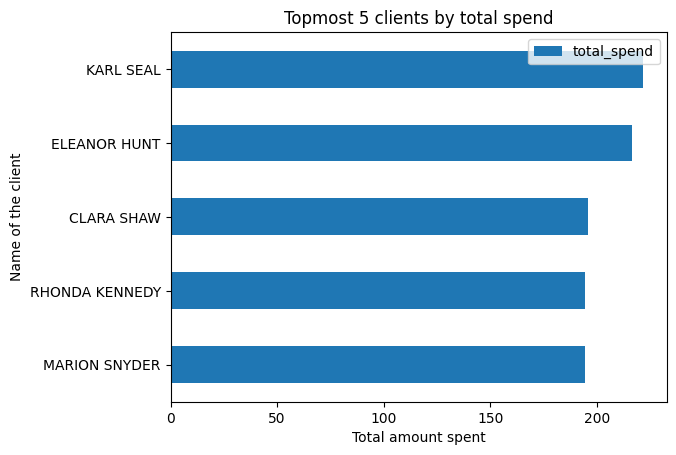

In [13]:
# task 2a) with the bar chart
#  a bar chart showing the top 5 customers by total spend.

ax = topmost_5_clients.head().plot(
    kind="barh",
    x="customer_name",
    y="total_spend",
    title="Topmost 5 clients by total spend",
    xlabel="Total amount spent",
    ylabel="Name of the client"    ,
)
ax.invert_yaxis()

In [14]:
# task 2b)
# How much money does each film category bring in? 
# Make a bar chart showing total revenue per film category.

income_per_category = duckdb.sql(""" 
 SELECT c.name AS category,
        SUM(p.amount) AS total_income
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.name
ORDER BY total_income DESC;
""").df()

income_per_category

,category,total_income
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


In [ ]:
# task 2b) with the bar chart
#  a bar chart showing total revenue per film category

ax = income_per_category.plot(
    kind="bar",
    x="category",
    y="total_income",
    title="Total revenue per film category",
    xlabel="Category",
    ylabel="Total amount revenue"
)

ax.invert_xaxis()

### Task 3

In [ ]:
# task 3)
#  The Manager wants some of your findings from task 1 and 2 to be included in the dashboard. 
# Make sure to combine relevant text, tables and graphs. 
# Also feel free to add more analysis and  graphs to the dashboard